# Atmospheric processes: from cloud to global scales
# Exercise on radar data

## Introduction

In this exercise, we will analyze radar measurements from the ICE GENESIS campaign that took place close in La Chaux-de-Fonds (NE) in January 2021.

We will look at data from two radars:

- The first one is referred to as **"WProf"**:
    - It is a 94 GHz (i.e. W-band) Doppler spectral zenith profiler (i.e. vertically-pointing). 
    - It was located in the city of la Chaux-de-Fonds.
    - You will look at timeseries of radar moments as well as radar Doppler spectra from single timesteps (last part of the exercise).
    - One particular feature is that it measures radar variables in three "chirps", corresponding to three altitude ranges. The first chirp ("chirp0") corresponds to measurements up to 1000 m , the second ("chirp1") from 1000m to 3500m and the last one ("chirp2") from 3500m to 8600m above ground. This information will be useful in the last part of the exercise.

- The second radar is referred to as **"MXPol"**:
    - It is a 9.4 GHz (i.e. X-band) polarimetric scanning radar.
    - It was located 4.8 km to the South-East of the site where WProf was deployed.
    - Its measurements consisted mainly of RHI (i.e. range-height indicators). This means that the radar scans across elevation angles, at a given azimuth (for further explanation, see e.g. http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml).
    - You will look at radar variables: radar equivalent reflectivity in horizontal polarization (Z$_H$), differential reflectivity (Z$_{DR}$), copolar correlation coefficient ($\rho_{hv}$)
    - You will also be provided with a product called "hydrometeor classification". The latter is derived using a semi-supervised algorithm (Besic et al., 2016, https://doi.org/10.5194/amt-9-4425-2016 ) which identifies the dominant hydrometeor type (e.g. rain, hail, snow aggregates) in the radar volumes.


In addition, we will use data from the COSMO high-resolution model (https://www.cosmo-model.org/), mostly to study the vertical structure of the atmosphere over la Chaux-de-Fonds at different timesteps. Note that the relative humidity variable corresponds to relative humidity with respect to liquid water.

The data that we will look at were collected between January 26 and January 28, 2021.

### General instructions
This exercise does not require to code in Python. You will simply have to execute the cells one after the other by pressing Shift + Enter. In a few cells, you will have to adjust the values of certain variables, which will be specified clearly.

The questions will guide you through an interpretation of the radar variables in terms of cloud or precipitation microphysical properties and processes.
The more difficult questions are indicated with a star (*).


### IMPORTANT 
**To run this notebook, make sure that the libraries are properly installed following the procedure in the README file provided.**




The cell below imports the required libraries and loads the data files to be used.

In [49]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
from metpy import calc
from metpy.units import units
import matplotlib.dates as mdates
import matplotlib as mpl
cmap_mask = mpl.colors.ListedColormap('lightgray')
import pandas as pd
date_fmt = mdates.DateFormatter('%d/%m\n%H:%M')
plt.rcParams['font.size']=15
from PIL import Image
import pyart

ALT_CDF = 1020.

radar = xr.open_dataset('Data/WPROF_CDF_ICEGENESIS_COMP_202101261000_202101282159.nc')
dt = [datetime.datetime.utcfromtimestamp(tt) for tt in radar.time]
ds_cosmo = xr.open_dataset('Data/COSMO_profiles_CDF_20210126_20210128.nc')


### Overview of the event

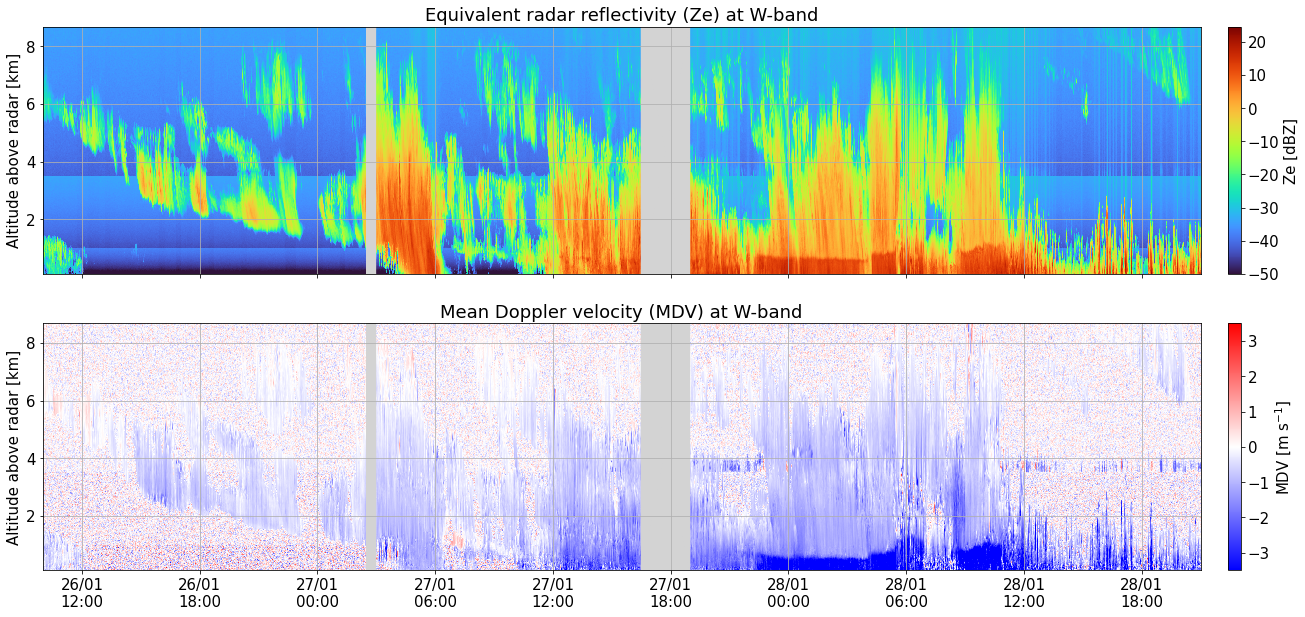

In [50]:
plt.rcParams['font.size']=15
fig, axs = plt.subplots(2,figsize=(25,10),sharey=True,sharex=True)
im0=axs[0].pcolormesh(dt,radar.range_gates, radar.Ze.T,cmap='turbo',vmin=-50)
plt.colorbar(im0,label='Ze [dBZ]',pad=0.02,ax=axs[0])
im1=axs[1].pcolormesh(dt,radar.range_gates, radar.mean_Doppler_velocity.T,cmap='bwr',vmin=-3.5,vmax=3.5)
plt.colorbar(im1,label='MDV [m s$^{-1}$]',pad=0.02,ax=axs[1])
axs[0].set_title('Equivalent radar reflectivity (Ze) at W-band')
axs[1].set_title('Mean Doppler velocity (MDV) at W-band')
for ax in axs:
    ax.set_facecolor('lightgray')
    ax.set_ylabel('Altitude above radar [km]')
    ax.set_xlim(datetime.datetime(2021,1,26,10),datetime.datetime(2021,1,28,21))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.pcolormesh([(datetime.datetime(2021,1,27,16,30)),datetime.datetime(2021,1,27,18,58)],[0,8.7],np.ones((2,2)),cmap = cmap_mask,shading='gouraud')
    ax.pcolormesh([(datetime.datetime(2021,1,27,2,30)),datetime.datetime(2021,1,27,2,58)],[0,8.7],np.ones((2,2)),cmap = cmap_mask,shading='gouraud')
    ax.set_ylim(radar.range_gates[0],radar.range_gates[-1])
    ax.grid()


> **Question 1**: Recall the physical meaning of radar reflectivity (Ze) and mean Doppler velocity (MDV). What are the radar targets here? What information do Ze and MDV respectively convey?

Before conducting further analyses, we will improve the quality of the figures by removing the background noise from the Ze and MDV variables.

For this, we will use a threshold on the signal-to-noise ratio (SNR), expressed in dB. In the cell below, we plot the SNR timeseries as well as the Ze and MDV timeseries after implementation of an SNR-based noise removal.\
**You will have to adjust the variable `SNR_THRESHOLD` to a value that you find suitable.** \
This value will be set for the rest of the exercise.

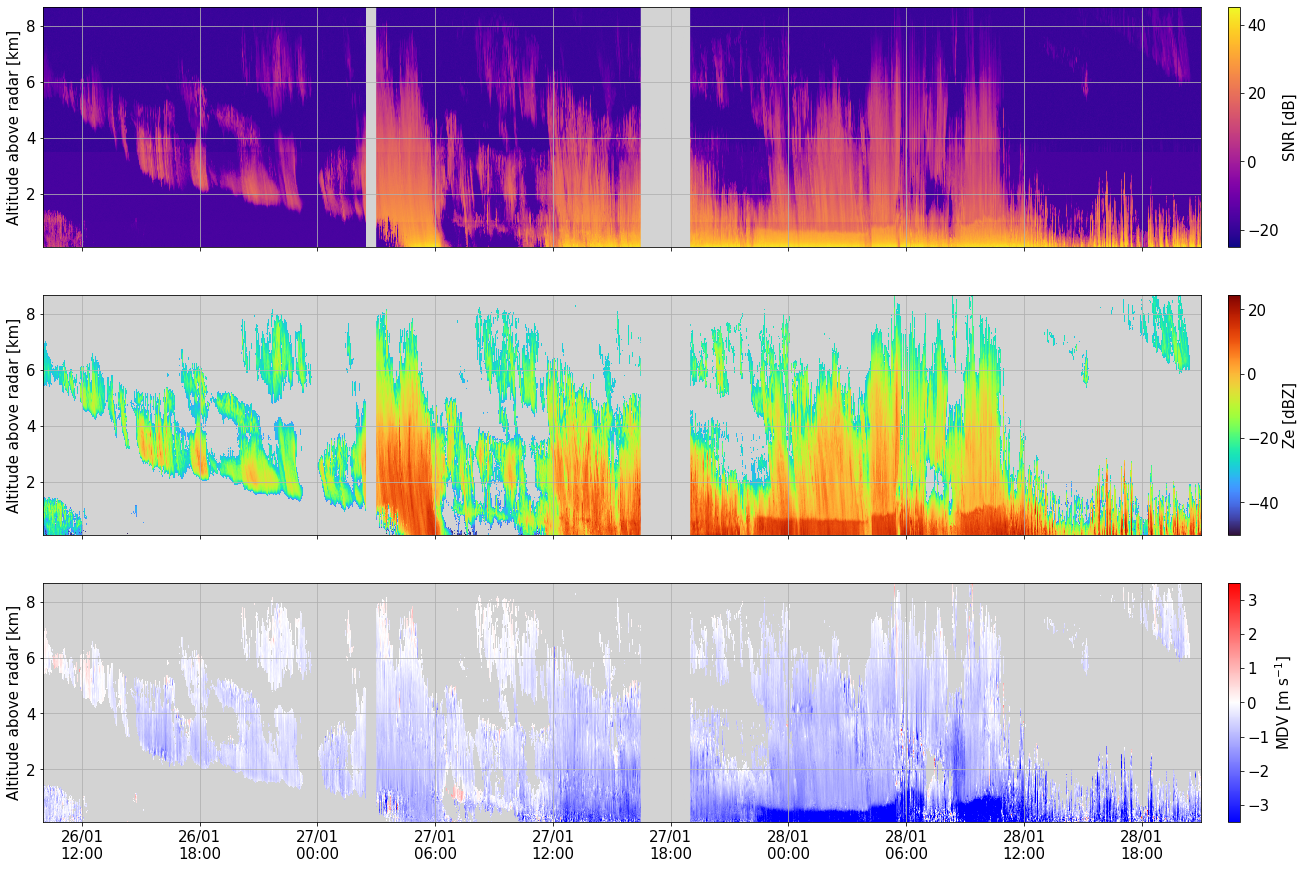

In [57]:
### variable to be changed
SNR_THRESHOLD = -15
#####

#Implementation of the mask:
radar = xr.open_dataset('Data/WPROF_CDF_ICEGENESIS_COMP_202101261000_202101282159.nc')
radar.Ze.values[radar.SNR<SNR_THRESHOLD]=np.nan
radar.mean_Doppler_velocity.values[radar.SNR<SNR_THRESHOLD]=np.nan

plt.rcParams['font.size']=15
fig, axs = plt.subplots(3,figsize=(25,15),sharey=True,sharex=True)
im0=axs[0].pcolormesh(dt,radar.range_gates, radar.SNR.T,cmap='plasma',vmin=-25)
plt.colorbar(im0,label='SNR [dB]',pad=0.02,ax=axs[0])
im1=axs[1].pcolormesh(dt,radar.range_gates, radar.Ze.T,cmap='turbo',vmin=-50)
plt.colorbar(im1,label='Ze [dBZ]',pad=0.02,ax=axs[1])
im2=axs[2].pcolormesh(dt,radar.range_gates, radar.mean_Doppler_velocity.T,cmap='bwr',vmin=-3.5,vmax=3.5)
plt.colorbar(im2,label='MDV [m s$^{-1}$]',pad=0.02,ax=axs[2])
for ax in axs:
    ax.set_facecolor('lightgray')
    ax.set_ylabel('Altitude above radar [km]')
    ax.set_xlim(datetime.datetime(2021,1,26,10),datetime.datetime(2021,1,28,21))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.pcolormesh([(datetime.datetime(2021,1,27,16,30)),datetime.datetime(2021,1,27,18,58)],[0,8.7],np.ones((2,2)),cmap = cmap_mask,shading='gouraud')
    ax.pcolormesh([(datetime.datetime(2021,1,27,2,30)),datetime.datetime(2021,1,27,2,58)],[0,8.7],np.ones((2,2)),cmap = cmap_mask,shading='gouraud')
    ax.set_ylim(radar.range_gates[0],radar.range_gates[-1])
    ax.grid()


> **Question 2**: What value did you choose for the threshold in SNR? Explain your choice.

> **Question 3**: When is precipitation observed at the ground, and what type(s) of precipitation is (are) observed? Explain.

> **Question 4**: Identify at least 3 different types of clouds in these timeseries.

We will now focus on different time frames within this precipitation event, looking at different radar variables.

### 03:00-06:30 UTC

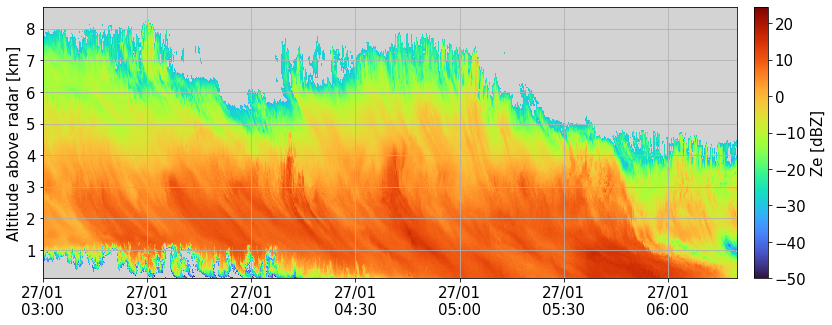

In [73]:
fig, ax = plt.subplots(1,figsize=(15,5),sharey=True,sharex=True)
im0=ax.pcolormesh(dt,radar.range_gates, radar.Ze.T,cmap='turbo',vmin=-50)
plt.colorbar(im0,label='Ze [dBZ]',pad=0.02,ax=ax)

ax.set_xlim(datetime.datetime(2021,1,26,10),datetime.datetime(2021,1,29,0))
ax.xaxis.set_major_formatter(date_fmt)
ax.grid()
ax.set_ylabel('Altitude above radar [km]')
_ =ax.set_xlim(datetime.datetime(2021,1,27,3,0),datetime.datetime(2021,1,27,6,20))
ax.set_facecolor('lightgray')


> **Question 5**: What microphysical process do you think is taking place below 1 km between 03UTC and 04:15UTC approximately? What might cause it? (e.g. in terms of atmospheric state variables)

> **Question 6 (*)**: Identify fall streaks of precipitation. Explain why we observe such structures. What do you think influences their shape (in terms of microphysical and/or atmospheric descriptors)?


In the cell below, we plot profiles of atmospheric variables above la Chaux-de-Fonds from the COSMO high-resolution model at 03:00 and 06:00 UTC.

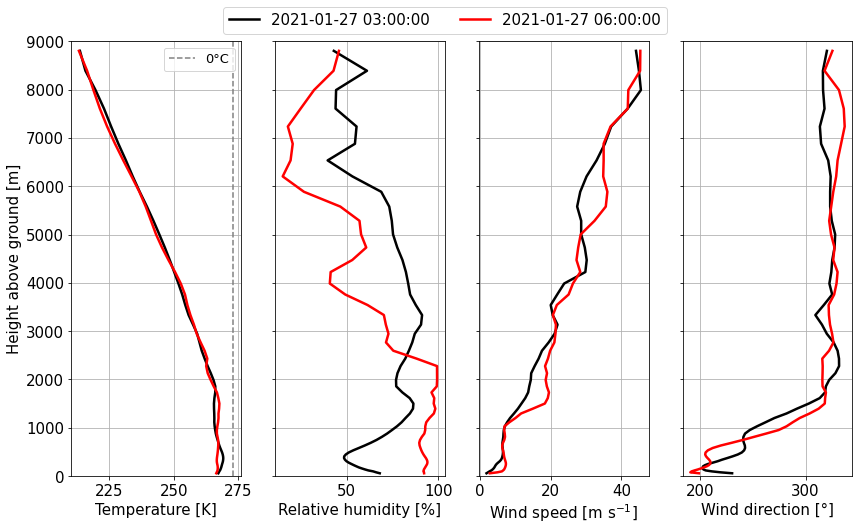

In [74]:
nt0 = 27
nt1 = 30
dt0 = pd.to_datetime(ds_cosmo['dt'][nt0].values)
dt1 = pd.to_datetime(ds_cosmo['dt'][nt1].values)

fig,axs = plt.subplots(1,4,figsize=(14,8),sharey=True)
axs[0].plot(ds_cosmo['temperature'][nt0,:],ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[0].plot(ds_cosmo['temperature'][nt1,:],ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5)
axs[0].plot([273.15,273.15],[0,10000],'--',color='gray',label='0°C')
axs[0].set_xlabel('Temperature [K]')
axs[0].legend(loc='upper right',fontsize=13)

axs[1].plot(ds_cosmo['RH'][nt0,:],ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5,label=dt0)
axs[1].plot(ds_cosmo['RH'][nt1,:],ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5,label=dt1)
axs[1].set_xlabel('Relative humidity [%]')

axs[2].plot(np.sqrt(ds_cosmo['U'][nt0,:]**2+ds_cosmo['V'][nt0,:]**2),ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[2].plot(np.sqrt(ds_cosmo['U'][nt1,:]**2+ds_cosmo['V'][nt1,:]**2),ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5)
axs[2].set_xlabel('Wind speed [m s$^{-1}$]')

axs[3].plot(270-180/np.pi*np.arctan(ds_cosmo['V'][nt0,:]/ds_cosmo['U'][nt0,:]),ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[3].plot(270-180/np.pi*np.arctan(ds_cosmo['V'][nt1,:]/ds_cosmo['U'][nt1,:]),ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5)
axs[3].set_xlabel('Wind direction [°]')

for ax in axs:
    ax.grid()
    ax.set_ylim(0,9000)
axs[1].legend(bbox_to_anchor=(1,1),loc='lower center',ncol=2)
_=axs[0].set_ylabel('Height above ground [m]')

> **Question 7.a)**: Looking at these profiles, what is the main change between 03 and 06UTC, and how does this relate to the radar reflectivity timeseries you observed before (03:00 - 06:30UTC)?

> **Question 7.b)**: Do these profiles help confirm / revisit your answers to questions 4, and how?

> **Question 7.c)**: How about question 5?


### 06:30-12:30 UTC

We now focus on a second short timeframe.


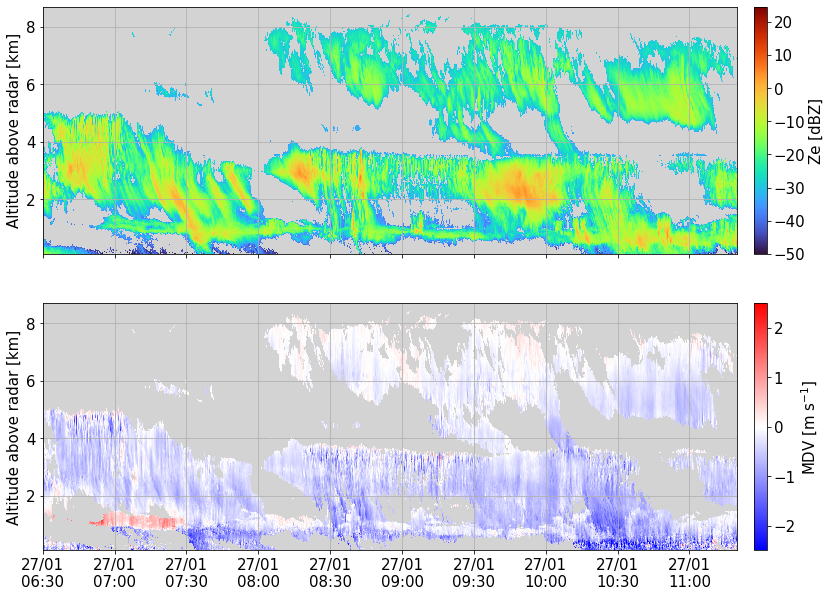

In [75]:
fig, axs = plt.subplots(2,1,figsize=(15,10),sharey=True,sharex=True)
im0=axs[0].pcolormesh(dt,radar.range_gates, radar.Ze.T,cmap='turbo',vmin=-50)
plt.colorbar(im0,label='Ze [dBZ]',pad=0.02,ax=axs[0])
im1=axs[1].pcolormesh(dt,radar.range_gates, radar.mean_Doppler_velocity.T,cmap='bwr',vmin=-2.5,vmax=2.5)
plt.colorbar(im1,label='MDV [m s$^{-1}$]',pad=0.02,ax=axs[1])

for ax in axs:
    ax.set_xlim(datetime.datetime(2021,1,27,6,30),datetime.datetime(2021,1,27,11,20))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.grid()
    ax.set_facecolor('lightgray')

    ax.set_ylabel('Altitude above radar [km]')



> **Question 8**: Identify signatures of clouds, precipitation, and virgae in these timeseries (define their temporal and altitude range).

> **Question 9**: Describe the structures that can be observed in radar reflectivity and mean Doppler velocity around 3-3.5km range, e.g. betw. 08:30 and 09:30 UTC? What do you think they can be due to? 
*Note: you can zoom into the timeseries by changing the bounds in the line:* `ax.set_xlim(datetime.datetime(2021,1,27,6,30),datetime.datetime(2021,1,27,12,20))`


> **Question 10 a)**: Look at the shallow layer around 1 km range, which persists from ~07:00UTC to ~11:00UTC. What do you think it corresponds to (take into account the signatures in Ze and Doppler velocity in your explanation)?

> **Question 10 b)**: What do you observe around 1 km range between ~06:50UTC and ~07:30UTC, in MDV?

Like before, we plot profiles of atmospheric variables above la Chaux-de-Fonds from the COSMO high-resolution model (https://www.cosmo-model.org/), this time at 09:00 and 11:00 UTC.

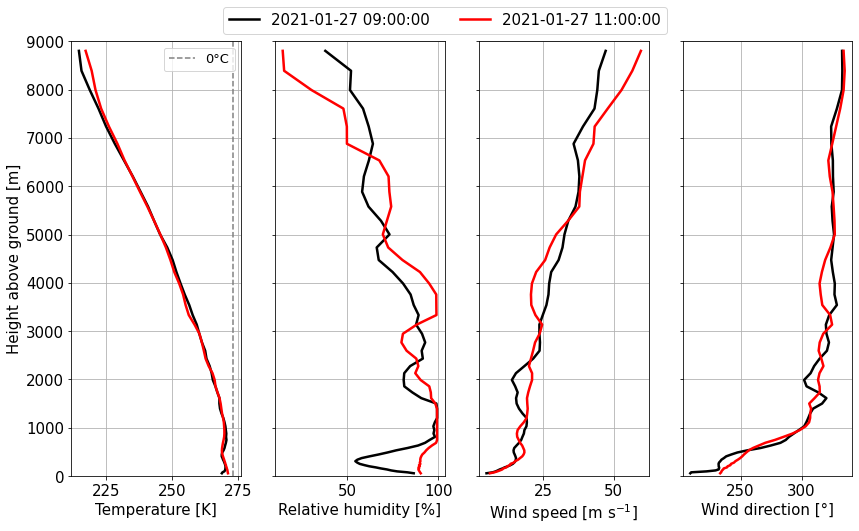

In [53]:
nt0 = 33
nt1 = 35
dt0 = pd.to_datetime(ds_cosmo['dt'][nt0].values)
dt1 = pd.to_datetime(ds_cosmo['dt'][nt1].values)

fig,axs = plt.subplots(1,4,figsize=(14,8),sharey=True)
axs[0].plot(ds_cosmo['temperature'][nt0,:],ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[0].plot(ds_cosmo['temperature'][nt1,:],ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5)
axs[0].plot([273.15,273.15],[0,10000],'--',color='gray',label='0°C')
axs[0].set_xlabel('Temperature [K]')
axs[0].legend(loc='upper right',fontsize=13)

axs[1].plot(ds_cosmo['RH'][nt0,:],ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5,label=dt0)
axs[1].plot(ds_cosmo['RH'][nt1,:],ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5,label=dt1)
axs[1].set_xlabel('Relative humidity [%]')

axs[2].plot(np.sqrt(ds_cosmo['U'][nt0,:]**2+ds_cosmo['V'][nt0,:]**2),ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[2].plot(np.sqrt(ds_cosmo['U'][nt1,:]**2+ds_cosmo['V'][nt1,:]**2),ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5)
axs[2].set_xlabel('Wind speed [m s$^{-1}$]')

axs[3].plot(270-180/np.pi*np.arctan(ds_cosmo['V'][nt0,:]/ds_cosmo['U'][nt0,:]),ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[3].plot(270-180/np.pi*np.arctan(ds_cosmo['V'][35,:]/ds_cosmo['U'][35,:]),ds_cosmo['z'][:]-ALT_CDF,'r',lw=2.5)
axs[3].set_xlabel('Wind direction [°]')
# plt.ylim
for ax in axs:
    ax.grid()
    ax.set_ylim(0,9000)
axs[1].legend(bbox_to_anchor=(1,1),loc='lower center',ncol=2)
_=axs[0].set_ylabel('Height above ground [m]')

> **Question 11 a)**: Are these profiles compatible with / do they confirm your answer to question 8?

> **Question 11 b) (*)**: Looking at the wind information, can you get an intuition of how this layer could be formed? 


### 13:00 - 14:30 UTC

In the next example, many signatures are visible. We focus for now on the layer with enhanced radar reflectivity around ~500m. 

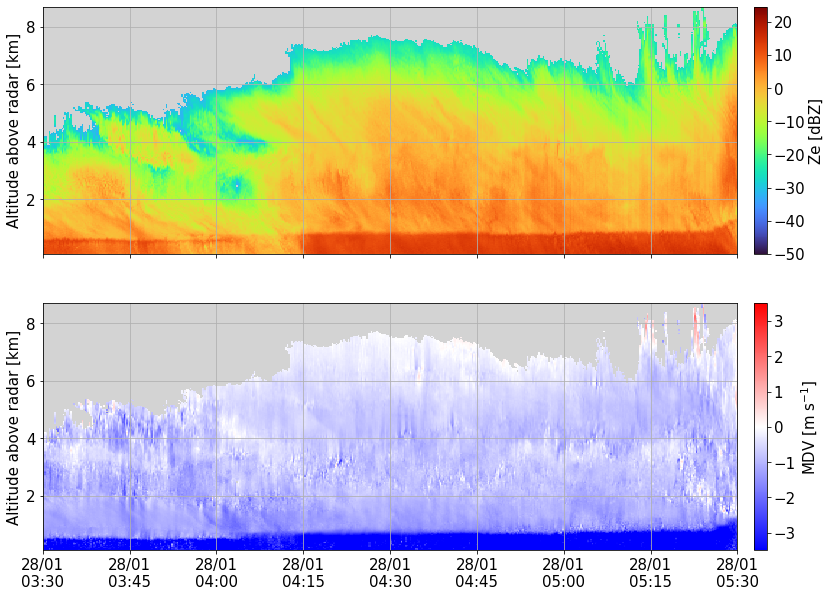

In [61]:
fig, axs = plt.subplots(2,1,figsize=(15,10),sharex=True)
im0=axs[0].pcolormesh(dt,radar.range_gates, radar.Ze.T,cmap='turbo',vmin=-50)
plt.colorbar(im0,label='Ze [dBZ]',pad=0.02,ax=axs[0])
im1=axs[1].pcolormesh(dt,radar.range_gates, radar.mean_Doppler_velocity.T,cmap='bwr',vmin=-3.5,vmax=3.5)
plt.colorbar(im1,label='MDV [m s$^{-1}$]',pad=0.02,ax=axs[1])
for ax in axs:
    ax.set_xlim(datetime.datetime(2021,1,28,3,30),datetime.datetime(2021,1,28,5,30))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.grid()
    ax.set_facecolor('lightgray')
    ax.set_ylabel('Altitude above radar [km]')

> **Question 12** What is happening around and below the 1000m level in these timeseries?


In complement to these W-band timeseries, we can look at the RHI measurements from MXPol.
We recall that at a given time step, the radar scans across elevation angles, at a given azimuth. 

In the figures below, the dashed black line indicates the vertical profile over la Chaux-de-Fonds (i.e. which is viewed by WProf).\
The legend for the hydrometeor classification is as follows: IH: Ice Hail / MH: Melting Hail / WS: Wet Snow / VI: Vertically-aligned Ice / RN: Rain / RP: Rimed Particles / LR: Light Rain / CR: Crystals / AG: Aggregates

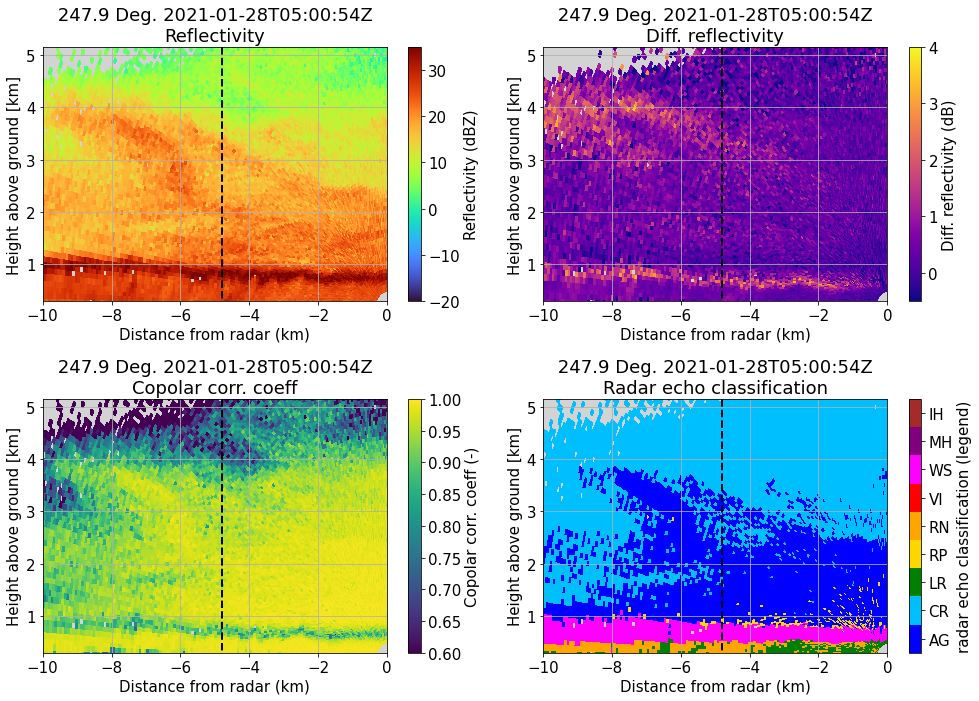

In [72]:
mxpol = pyart.io.read_cfradial('Data/MXPOL_RHI_20210128-050056.nc')
Rhohv = mxpol.fields['Rhohv']['data'].data
Psidp = mxpol.fields['Psidp']['data'].data
mask_from_rhohv = (Rhohv<0.35) | (Psidp>-30)
mxpol.fields['Zh']['data'].mask=mask_from_rhohv
mxpol.fields['Zdr']['data'].mask=mask_from_rhohv
mxpol.fields['Rhohv']['data'].mask=mask_from_rhohv
mxpol.fields['Kdp']['data'].mask=mask_from_rhohv
mxpol.fields['Psidp']['data'].mask=mask_from_rhohv
mxpol.fields['RVel']['data'].mask=mask_from_rhohv
mxpol.fields['hydro']['data'].mask=mask_from_rhohv
mxpol.fields['hydro']['data'][mxpol.fields['hydro']['data']>200.] = np.nan

vdopmin=-41
vdopmax=41

fig,axs = plt.subplots(2,2,figsize=(14,10))
display = pyart.graph.RadarDisplay(mxpol)
display.plot('Zh',vmin=-20,vmax=35,cmap='turbo',ax=axs[0,0])
display.plot('Zdr',vmin=-.5,vmax=4,cmap='plasma',ax=axs[0,1])
display.plot('Rhohv',vmin=0.6,vmax=1,cmap='viridis',ax=axs[1,0])
cmap = mpl.colors.ListedColormap(["blue", "deepskyblue", "green", "gold", "orange", "red", 'magenta', 'purple','brown'])
norm = mpl.colors.BoundaryNorm(np.arange(2,12), cmap.N) 
cbarticks = np.arange(2,11)+.5
legendNoVI = ['AG', 'CR', 'LR', 'RP', 'RN', 'VI', 'WS', 'MH', 'IH']
cax = display.plot('hydro',cmap=cmap,norm=norm,ticks=cbarticks,ticklabs=legendNoVI,ax=axs[1,1])
cbar = display.cbs[0]

for ax in axs.flatten():
    ax.set_facecolor('lightgray')    
    ax.set_yticks(np.arange(0,6)-0.150)
    ax.set_yticklabels(np.arange(0,6))
    ax.set_ylim(0.15,5)
    ax.set_xlim(-10,0)
    ax.grid()
    ax.plot([-4.8,-4.8],[0,6],'--k',lw=2)
    ax.set_ylabel('Height above ground [km]')
fig.tight_layout()

> **Question 13 a)**: What do those features (i.e. the ones you identified in the previous question) correspond to in the RHIs of MXPol? Look at the different variables and the hydrometeor classification.

> **Question 13 b) (*)**: What do the high and low Zdr features in the top left of the RHI (above 3 km, between -10 and -8 km) correspond to in the hydrometeor classification? Why?

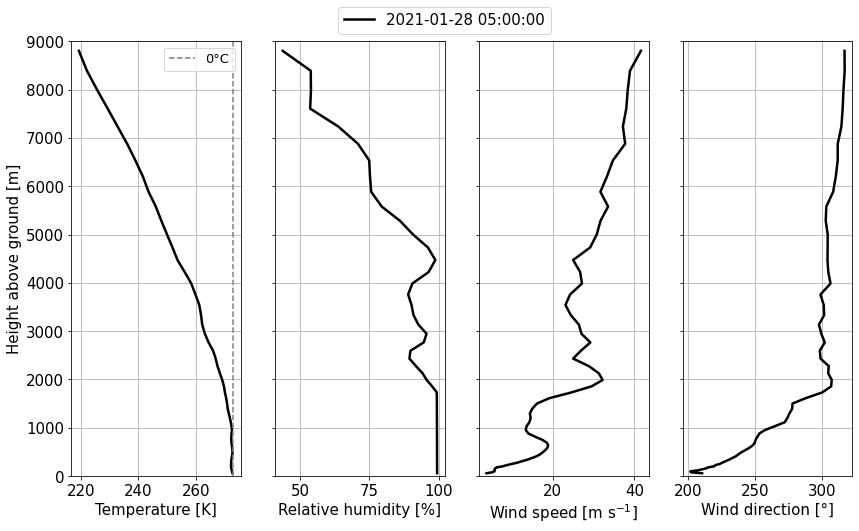

In [64]:
ds_cosmo = xr.open_dataset('Data/COSMO_profiles_CDF_20210126_20210128.nc')
nt0 = 53
dt0 = pd.to_datetime(ds_cosmo['dt'][nt0].values)

fig,axs = plt.subplots(1,4,figsize=(14,8),sharey=True)
axs[0].plot(ds_cosmo['temperature'][nt0,:],ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[0].plot([273.15,273.15],[0,10000],'--',color='gray',label='0°C')
axs[0].set_xlabel('Temperature [K]')
axs[0].legend(loc='upper right',fontsize=13)

axs[1].plot(ds_cosmo['RH'][nt0,:],ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5,label=dt0)
axs[1].set_xlabel('Relative humidity [%]')

axs[2].plot(np.sqrt(ds_cosmo['U'][nt0,:]**2+ds_cosmo['V'][nt0,:]**2),ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[2].set_xlabel('Wind speed [m s$^{-1}$]')

axs[3].plot(270-180/np.pi*np.arctan(ds_cosmo['V'][nt0,:]/ds_cosmo['U'][nt0,:]),ds_cosmo['z'][:]-ALT_CDF,'k',lw=2.5)
axs[3].set_xlabel('Wind direction [°]')
# plt.ylim
for ax in axs:
    ax.grid()
    ax.set_ylim(0,9000)
axs[1].legend(bbox_to_anchor=(1,1),loc='lower center',ncol=2)
_=axs[0].set_ylabel('Height above ground [m]')

> **Question 14** Are the COSMO profiles consistent with your interpretation of the radar measurements (questions 12 and 13.a)?

## Doppler spectra

In the last part of this exercise, we look at Doppler spectra measured by the W-band radar, during different stages of the event.

First, we focus on an example of Doppler spectra measured at 05:09UTC. In the cell below, we display the entire "spectrogram", i.e. the vertical stack of Doppler spectra measured at each range gate.

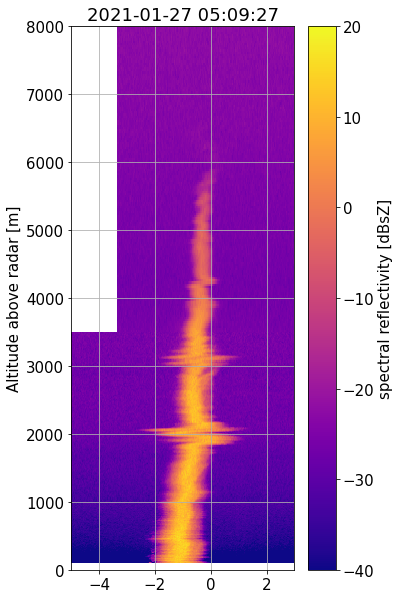

In [65]:
ds= xr.open_dataset('Data/210127_050927_LV0.nc')

plt.figure(figsize=(5,10))
dv0 = ds['vel0'][1]-ds['vel0'][0]
dv1 = ds['vel1'][1]-ds['vel1'][0]
dv2 = ds['vel2'][1]-ds['vel2'][0]
plt.pcolormesh(ds['vel0'],ds['rg0'],10*np.log10(ds['spec0']/dv0),vmin=-40,vmax=20,cmap='plasma')
plt.pcolormesh(ds['vel1'],ds['rg1'],10*np.log10(ds['spec1']/dv1),vmin=-40,vmax=20,cmap='plasma')
plt.pcolormesh(ds['vel2'],ds['rg2'],10*np.log10(ds['spec2']/dv2),vmin=-40,vmax=20,cmap='plasma')
plt.title(ds.date)
plt.xlim(-5,3)
plt.grid()
plt.colorbar(label='spectral reflectivity [dBsZ]')
plt.ylabel('Altitude above radar [m]')
_ =plt.ylim(0,8000)


If we want to be more precise, we can also look at a single Doppler spectrum, at a chosen range gate. In the following cell, you can change the variables `chirp` and `nrg` which allow you to choose the range gate at which to plot the Doppler spectrum.

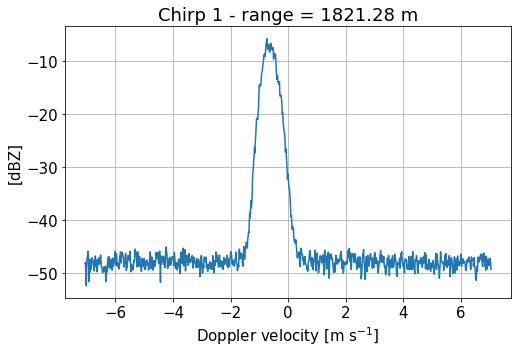

In [66]:
### variables that can be changed 
chirp = 1 # Should be 0 (lowest), 1, or 2 (highest)
nrg = 50
#####
plt.figure(figsize=(8,5))
plt.plot(ds['vel%d'%chirp],10*np.log10(ds['spec%d'%chirp][nrg,:]))
plt.title('Chirp %d - range = %.2f m'%(chirp,ds['rg%d'%chirp][nrg]))
plt.grid()
plt.ylabel('[dBZ]')
_=plt.xlabel('Doppler velocity [m s$^{-1}$]')

> **Question 15**: Explain how Doppler spectra can help get insight into the microphysical properties of clouds or precipitation. 

> **Question 16**: Look at the full spectrogram plotted above (27/01, 05:09 UTC). What do you observe at ~2000m and ~3000m above ground, and what do you think it reveals?

> **Question 17 (*)**: Starting from the top of the spectrogram, indicate what are in your view the microphysical processes (e.g. growth/ decay mechanisms) that are taking place ? 

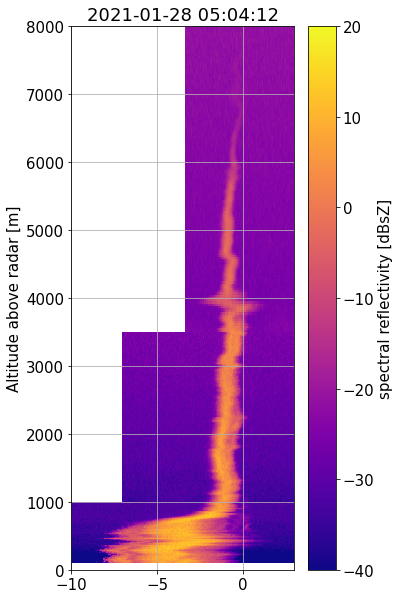

In [67]:
ds= xr.open_dataset('Data/210128_050412_LV0.nc')

plt.figure(figsize=(5,10))
dv0 = ds['vel0'][1]-ds['vel0'][0]
dv1 = ds['vel1'][1]-ds['vel1'][0]
dv2 = ds['vel2'][1]-ds['vel2'][0]
plt.pcolormesh(ds['vel0'],ds['rg0'],10*np.log10(ds['spec0']/dv0),vmin=-40,vmax=20,cmap='plasma')
plt.pcolormesh(ds['vel1'],ds['rg1'],10*np.log10(ds['spec1']/dv1),vmin=-40,vmax=20,cmap='plasma')
plt.pcolormesh(ds['vel2'],ds['rg2'],10*np.log10(ds['spec2']/dv2),vmin=-40,vmax=20,cmap='plasma')
plt.title(ds.date)
plt.xlim(-10,3)
plt.grid()
plt.colorbar(label='spectral reflectivity [dBsZ]')
plt.ylabel('Altitude above radar [m]')
_ =plt.ylim(0,8000)


> **Question 18**: In this new example (28/01, 05:04 UTC), make the link between what you observe in the spectrogram and your answers to question 12: where do you see the signatures that were visible in Ze and MDV? What additional information do you get from the spectrogram (compared to the timeseries), focusing on altitudes below 1000 m?

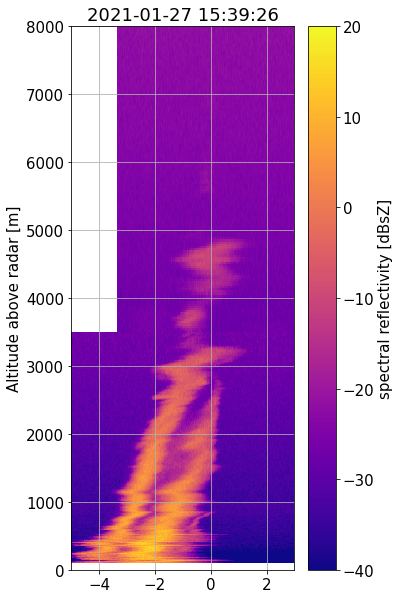

In [68]:
ds= xr.open_dataset('Data/210127_153926_LV0.nc')

plt.figure(figsize=(5,10))
dv0 = ds['vel0'][1]-ds['vel0'][0]
dv1 = ds['vel1'][1]-ds['vel1'][0]
dv2 = ds['vel2'][1]-ds['vel2'][0]
plt.pcolormesh(ds['vel0'],ds['rg0'],10*np.log10(ds['spec0']/dv0),vmin=-40,vmax=20,cmap='plasma')
plt.pcolormesh(ds['vel1'],ds['rg1'],10*np.log10(ds['spec1']/dv1),vmin=-40,vmax=20,cmap='plasma')
plt.pcolormesh(ds['vel2'],ds['rg2'],10*np.log10(ds['spec2']/dv2),vmin=-40,vmax=20,cmap='plasma')
plt.title(ds.date)
plt.xlim(-5,3)
plt.grid()
plt.colorbar(label='spectral reflectivity [dBsZ]')
plt.ylabel('Altitude above radar [m]')
_ =plt.ylim(0,8000)


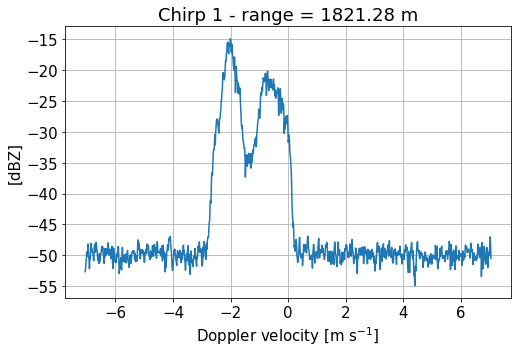

In [69]:
### variables that can be changed 
chirp = 1 # Should be 0 (lowest), 1, or 2 (highest)
nrg = 50
#####
plt.figure(figsize=(8,5))
plt.plot(ds['vel%d'%chirp],10*np.log10(ds['spec%d'%chirp][nrg,:]))
plt.title('Chirp %d - range = %.2f m'%(chirp,ds['rg%d'%chirp][nrg]))
plt.grid()
plt.ylabel('[dBZ]')
_=plt.xlabel('Doppler velocity [m s$^{-1}$]')

> **Question 19 a)**: In this last example (27/01, 15:39 UTC), the spectrogram looks very different. Explain what this multimodal signature reveals.

> **Question 19 b)**: What microphysical processes can be happening here? Try to address in particular the following points: what does the Doppler velocity of the leftmost mode suggest? What could cause the occurrence of the second mode below ~3000 m?

In the cell below, we display an image collected by an aircraft performing in-situ measurements above the ground site where the radars were deployed, with an HVPS probe (https://airbornescience.nasa.gov/instrument/HVPS). Each line of the image should be interpreted as an instantaneous binary image of the volume "viewed" by the probe.
At 15:39 UTC, the aircraft was flying just above WProf, at an altitude of 1100m above ground.

> **Question 20**: Comment the image and put it in perspective with your answers to questions 15 a) and b). What would each mode correspond to? Explain the signatures in terms of both velocity and reflectivity.



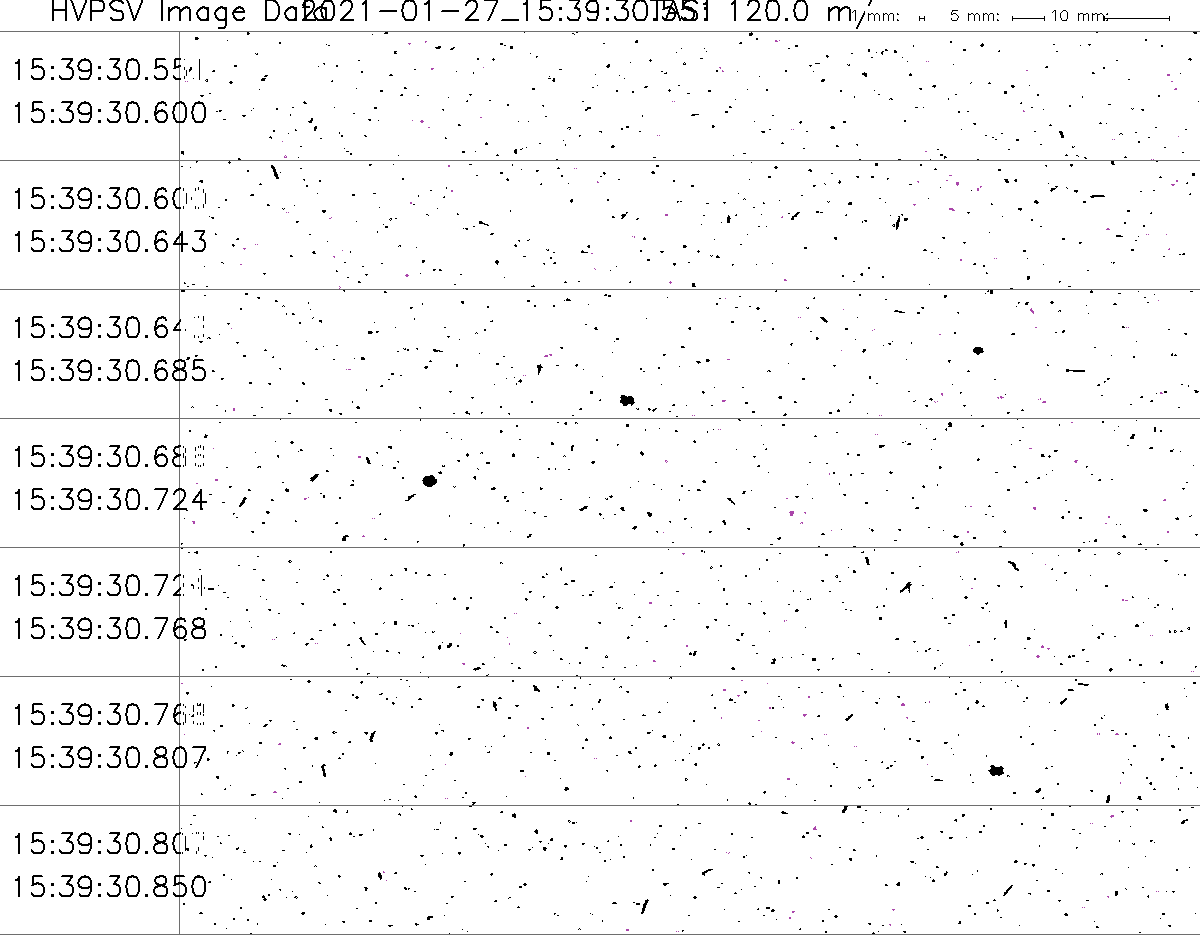

In [70]:
Image.open('Data/Proj_Plat_HVPS_V_20210127_153930_551_153930_850_N04927.png')